# Intro to AI CW2 - Support Vector Regression Attempt

### 1. Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.model_selection import  cross_validate, learning_curve, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [3]:
df = pd.read_csv('index.csv')
df.insert(0, "Date", pd.to_datetime(df[["Year", "Month", "Day"]]))      # create datetime column
df.set_index(["Date"], inplace=True)                                    # set index to date, easy to handle 
df.drop(columns=["Year", "Month", "Day"], inplace=True)                 # deop redundant columns
df.drop(columns=["Federal Funds Target Rate", "Federal Funds Upper Target", "Federal Funds Lower Target"], inplace=True)        # these columns will not be used


targ_df = pd.DataFrame(df["Real GDP (Percent Change)"])     # create target and drop the NaNs to get to quarterly values


# determine date when inflation rate begins to ve recorded 
for i,j in enumerate(df["Inflation Rate"]):
    if not np.isnan(j):
        print(f"Inflation rates begin: {df.index[i]}")
        break        
 
df.drop(df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
df.drop(df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates
targ_df.drop(targ_df.loc["1954-07-01":"1958-01-01"].index, inplace=True)      # drop the rows with no inflation rate
targ_df.drop(targ_df.loc["2016-11-01":].index, inplace=True) # drop as there is no target for these dates



# remove mid-month entries as these were wgen target rates were chanmged, theses only contain NaNs for our feqture vaeriables 
idx_mm = [i for i,j in enumerate(df.index.day) if j != 1]
df.drop(df.iloc[idx_mm].index, inplace=True) 
# same for targ df
idx_mm = [i for i,j in enumerate(targ_df.index.day) if j != 1]
targ_df.drop(targ_df.iloc[idx_mm].index, inplace=True) 




tss = TimeSeriesSplit(n_splits = 2)         # use time series train test split so we do not train on future data, 2 splits to increse cv sample size
for train_index, test_index in tss.split(df, targ_df):
    X_train, X_test = df.iloc[train_index, :].copy(), df.iloc[test_index,:].copy()
    y_train, y_test = targ_df.iloc[train_index].copy(), targ_df.iloc[test_index].copy()
X_train.drop(columns="Real GDP (Percent Change)", inplace=True)
X_test.drop(columns="Real GDP (Percent Change)", inplace=True)



lags = [1,2,3,4,5]        # introduce lag features 
cols = ["Effective Federal Funds Rate", "Inflation Rate", "Unemployment Rate"]  
# loop and dynamically name lags for train
for col in cols:
    for L in lags:
        X_train[f"{col} lag{L}"] = X_train[col].shift(L)
# same for test
for col in cols:
    for L in lags:
        X_test[f"{col} lag{L}"] = X_test[col].shift(L)


X_train.drop(X_train.iloc[0:5].index, inplace=True)
X_test.drop(X_test.iloc[0:5].index, inplace=True)

# Now need to reduce to quartely evaluation: 
y_train = y_train.loc["1958-08-01":"1997-03-01"]        # limits of X_train
y_train = y_train.dropna()                              # get rid of monthly values
X_train = X_train.loc[y_train.index]                    # use index of targ to change X
print(f"Check indices: {sum(y_train.index != X_train.index)}")                     # check

# same for test dataset
y_test = y_test.loc["1997-10-01":"2016-10-01"]
y_test = y_test.dropna()
X_test = X_test.loc[y_test.index]
print(f"check indices: {sum(y_test.index != X_test.index)}")

# create quarterly lags for GDP
gdp_lags = [1,2,3]
for L in gdp_lags:
    X_train[f"Real GDP (Percent Change) lag{L}"] = y_train["Real GDP (Percent Change)"].shift(L)

for L in gdp_lags:
    X_test[f"Real GDP (Percent Change) lag{L}"] = y_test["Real GDP (Percent Change)"].shift(L)

X_train.drop(X_train.iloc[0:3].index, inplace=True)
X_test.drop(X_test.iloc[0:3].index, inplace=True)
y_train.drop(X_train.iloc[0:3].index, inplace=True)
y_test.drop(X_test.iloc[0:3].index, inplace=True)

print(f'NaNs in X_train: {X_train[["Unemployment Rate", "Effective Federal Funds Rate", "Inflation Rate"]].isna().sum()}')       # check if all are removed
print(f'NaNs in y_train: {y_train["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed
print(f'NaNs in X_test: {X_test[["Unemployment Rate", "Effective Federal Funds Rate", "Inflation Rate"]].isna().sum()}')        # check if all are removed
print(f'NaNs in y_test: {y_test["Real GDP (Percent Change)"].isna().sum()}')        # check if all are removed


X_train.head(6)

Inflation rates begin: 1958-01-01 00:00:00
Check indices: 0
check indices: 0
NaNs in X_train: Unemployment Rate               0
Effective Federal Funds Rate    0
Inflation Rate                  0
dtype: int64
NaNs in y_train: 0
NaNs in X_test: Unemployment Rate               0
Effective Federal Funds Rate    0
Inflation Rate                  0
dtype: int64
NaNs in y_test: 0


,Effective Federal Funds Rate,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate lag1,Effective Federal Funds Rate lag2,Effective Federal Funds Rate lag3,Effective Federal Funds Rate lag4,Effective Federal Funds Rate lag5,Inflation Rate lag1,Inflation Rate lag2,...,Inflation Rate lag4,Inflation Rate lag5,Unemployment Rate lag1,Unemployment Rate lag2,Unemployment Rate lag3,Unemployment Rate lag4,Unemployment Rate lag5,Real GDP (Percent Change) lag1,Real GDP (Percent Change) lag2,Real GDP (Percent Change) lag3
Date,,,,,,,,,,,,,,,,,,,,,
1959-07-01,3.47,5.1,2.0,3.39,2.90,2.96,2.80,2.43,2.0,2.0,...,1.7,1.7,5.0,5.1,5.2,5.6,5.9,10.1,7.7,9.7
1959-10-01,3.98,5.7,2.7,3.76,3.50,3.47,3.39,2.90,2.4,2.0,...,2.0,2.0,5.5,5.2,5.1,5.0,5.1,-0.8,10.1,7.7
1960-01-01,3.99,5.2,2.0,3.99,4.00,3.98,3.76,3.50,2.0,2.0,...,2.4,2.0,5.3,5.8,5.7,5.5,5.2,1.6,-0.8,10.1
1960-04-01,3.92,5.2,2.0,3.84,3.97,3.99,3.99,4.00,2.0,2.3,...,2.0,2.0,5.4,4.8,5.2,5.3,5.8,9.2,1.6,-0.8
1960-07-01,3.23,5.5,1.3,3.32,3.85,3.92,3.84,3.97,1.7,1.7,...,2.0,2.3,5.4,5.1,5.2,5.4,4.8,-1.5,9.2,1.6
1960-10-01,2.47,6.1,1.0,2.60,2.98,3.23,3.32,3.85,1.0,1.3,...,1.7,1.7,5.5,5.6,5.5,5.4,5.1,1.0,-1.5,9.2


In [4]:
abs(X_train.corrwith(y_train["Real GDP (Percent Change)"])).sort_values(ascending=False)

Effective Federal Funds Rate lag4    0.427075
Effective Federal Funds Rate lag5    0.417335
Effective Federal Funds Rate lag3    0.411639
Effective Federal Funds Rate lag2    0.374603
Effective Federal Funds Rate lag1    0.340545
Inflation Rate                       0.338071
Inflation Rate lag1                  0.335855
Inflation Rate lag2                  0.334910
Effective Federal Funds Rate         0.325568
Inflation Rate lag3                  0.318757
Inflation Rate lag4                  0.302891
Real GDP (Percent Change) lag1       0.287994
Inflation Rate lag5                  0.274062
Real GDP (Percent Change) lag2       0.216453
Unemployment Rate lag5               0.193678
Unemployment Rate lag4               0.167927
Unemployment Rate lag3               0.140050
Unemployment Rate lag2               0.108619
Unemployment Rate lag1               0.068909
Real GDP (Percent Change) lag3       0.053908
Unemployment Rate                    0.001200
dtype: float64

### Support Vector Regression (SVR) -- Changes from here

R²         | MSE        | MAE        |
-0.5215    | 9.2776     | 2.2782     | 


/home/yukisuter/AI4-CW2/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


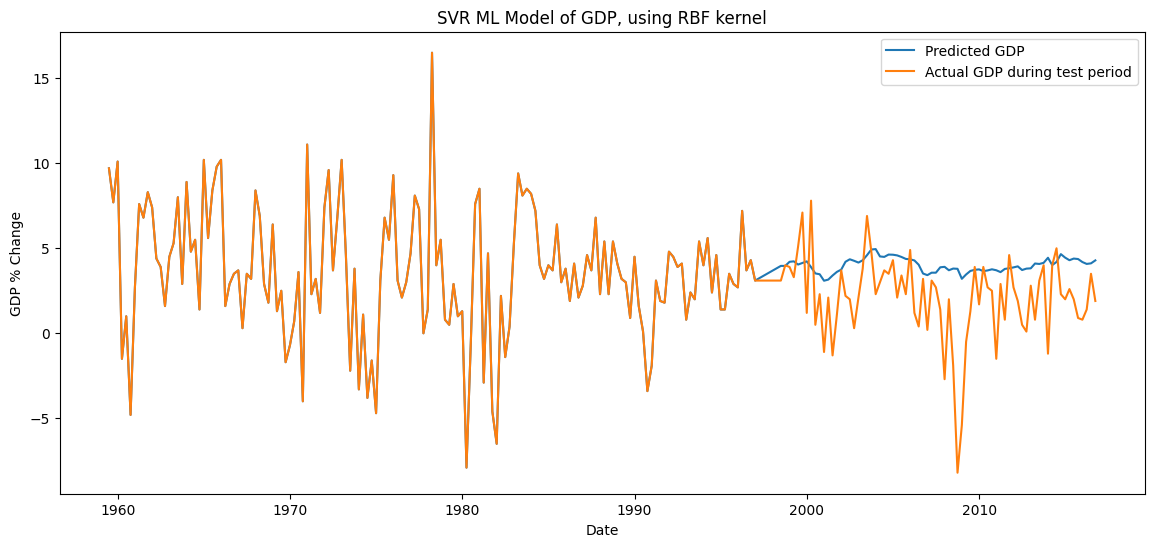

In [5]:
from sklearn.svm import SVR

svr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel='rbf'))
])

svr_pipe.fit(X_train, y_train)
gdp_pred = svr_pipe.predict(X_test)

r2 = r2_score(y_test, gdp_pred)
MSe = mean_squared_error(y_test, gdp_pred)
MAe = mean_absolute_error(y_test, gdp_pred)

print(f"{'R²':<10} | {'MSE':<10} | {'MAE':<10} |")

print(
        f"{r2:<10.4f} | "
        f"{MSe:<10.4f} | "
        f"{MAe:<10.4f} | "
    )

plt.figure(figsize=(14, 6))
plt.plot(pd.concat([X_train, X_test]).index, np.concatenate([y_train['Real GDP (Percent Change)'], gdp_pred]), label="Predicted GDP")
plt.plot(pd.concat([X_train, X_test]).index, pd.concat([y_train, y_test]), label="Actual GDP during test period")
plt.legend()
plt.title("SVR ML Model of GDP, using RBF kernel")
plt.xlabel("Date")
plt.ylabel("GDP % Change")
plt.show()

The graph above shows some basic trend that follows the real world data, but its very rough. Some tuning should be performed to try and get this to be more reliable.

This will be done using a gridsearch to find what the best performing parameters for the SVR regression are:

In [6]:
# Define parameter grid
param_grid = {
    "model__C": [0.1, 1, 10, 100],
    "model__epsilon": [0.01, 0.1, 0.5, 1.0],
    "model__gamma": ["scale", "auto", 0.01, 0.1, 1.0],
}

# Time-series aware CV (keeps temporal order)
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=svr_pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring="r2",  # you can try 'r2' as well
    n_jobs=-1,                         # use all cores if available
    verbose=1
)

# If y_train is a DataFrame, flatten it to 1D
y_train_1d = y_train.squeeze()

grid_search.fit(X_train, y_train_1d)

print("Best params:", grid_search.best_params_)
print("Best CV score (r2):", grid_search.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best params: {'model__C': 0.1, 'model__epsilon': 0.01, 'model__gamma': 0.01}
Best CV score (r2): -0.09200845407986968


Based on the output above, these parameters will be used to generate a graph to analyse:

R²         | MSE        | MAE        |
-0.5019    | 9.1582     | 2.2052     | 


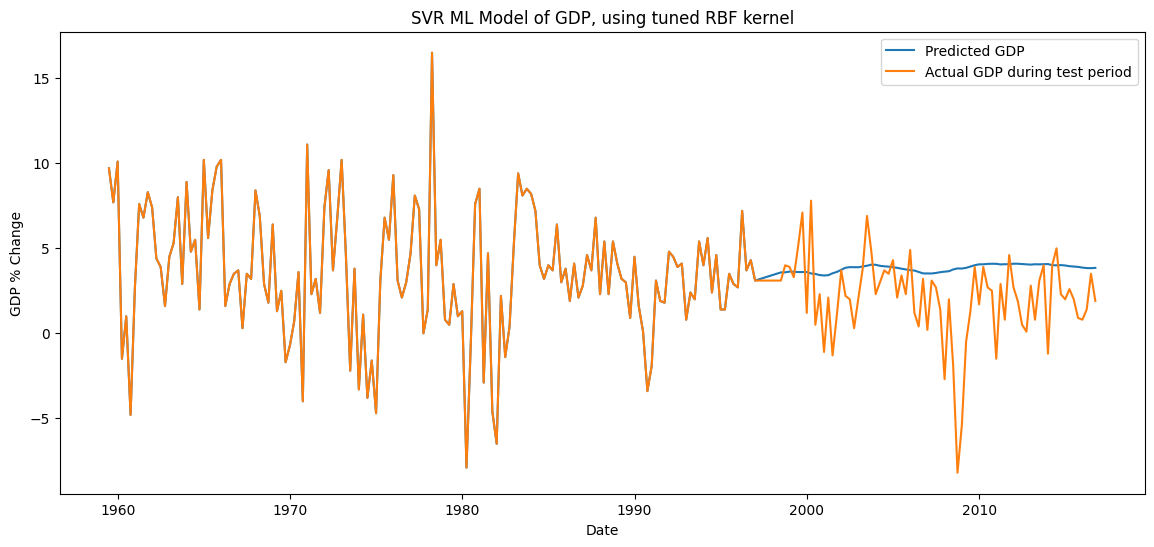

In [7]:
best_svr_pipe = grid_search.best_estimator_

best_svr_pipe.fit(X_train, y_train_1d)  # optional, already refit by default
gdp_pred = best_svr_pipe.predict(X_test)

r2  = r2_score(y_test, gdp_pred)
MSe = mean_squared_error(y_test, gdp_pred)
MAe = mean_absolute_error(y_test, gdp_pred)

print(f"{'R²':<10} | {'MSE':<10} | {'MAE':<10} |")
print(
    f"{r2:<10.4f} | "
    f"{MSe:<10.4f} | "
    f"{MAe:<10.4f} | "
)

plt.figure(figsize=(14, 6))
plt.plot(
    pd.concat([X_train, X_test]).index,
    np.concatenate([y_train['Real GDP (Percent Change)'], gdp_pred]),
    label="Predicted GDP"
)
plt.plot(
    pd.concat([X_train, X_test]).index,
    pd.concat([y_train, y_test]),
    label="Actual GDP during test period"
)
plt.legend()
plt.title("SVR ML Model of GDP, using tuned RBF kernel")
plt.xlabel("Date")
plt.ylabel("GDP % Change")
plt.show()


The graph has gotten significantly worse, and may be due to the way in which the gridsearch is performed where a low r^2 is prioritised, which can have a better result with a flatter, less representative graph.

Fitting 5 folds for each of 80 candidates, totalling 400 fits


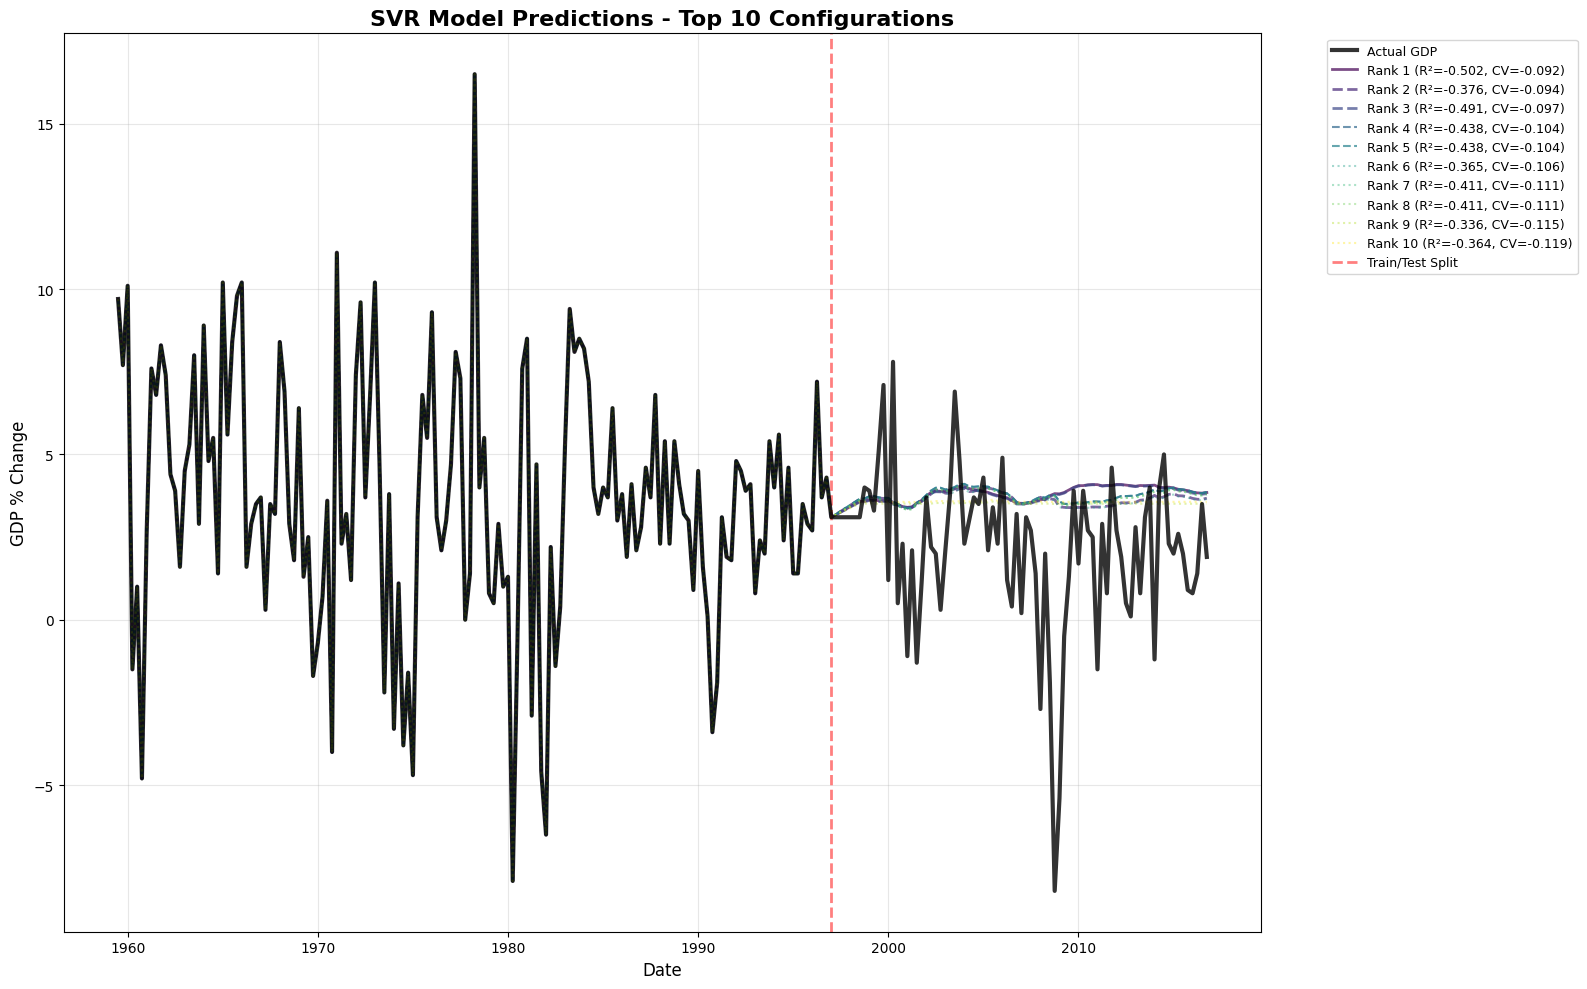


DETAILED METRICS FOR TOP 10 MODELS
Rank   | Test R²    | CV R²      | MSE          | MAE          | Parameters
------------------------------------------------------------------------------------------------------------------------
1      | -0.5019    | -0.0920    | 9.1582       | 2.2052       | C=0.1, epsilon=0.01, gamma=0.01
2      | -0.3762    | -0.0942    | 8.3915       | 2.0856       | C=0.1, epsilon=0.01, gamma=0.1
3      | -0.4906    | -0.0970    | 9.0893       | 2.1916       | C=0.1, epsilon=0.1, gamma=0.01
4      | -0.4378    | -0.1038    | 8.7673       | 2.1514       | C=0.1, epsilon=0.01, gamma=auto
5      | -0.4378    | -0.1038    | 8.7673       | 2.1514       | C=0.1, epsilon=0.01, gamma=scale
6      | -0.3653    | -0.1065    | 8.3254       | 2.0729       | C=0.1, epsilon=0.1, gamma=0.1
7      | -0.4107    | -0.1109    | 8.6021       | 2.1206       | C=0.1, epsilon=0.1, gamma=scale
8      | -0.4107    | -0.1109    | 8.6021       | 2.1206       | C=0.1, epsilon=0.1, gamma=

In [12]:
param_grid = {
    "model__C": [0.1, 1, 10, 100],
    "model__epsilon": [0.01, 0.1, 0.5, 1.0],
    "model__gamma": ["scale", "auto", 0.01, 0.1, 1.0],
}

# Time-series aware CV (keeps temporal order)
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=svr_pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# If y_train is a DataFrame, flatten it to 1D
y_train_1d = y_train.squeeze()

grid_search.fit(X_train, y_train_1d)

# Extract results and get top N models
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
sorted_indices = np.argsort(mean_test_scores)[::-1]

# Choose how many models to plot (adjust this number)
top_n = 10  # Plot top 10 models, or set to len(sorted_indices) for all

# Create figure
plt.figure(figsize=(16, 10))

# Plot actual GDP
full_index = pd.concat([X_train, X_test]).index
actual_gdp = pd.concat([y_train, y_test])
plt.plot(full_index, actual_gdp, 'k-', linewidth=3, label='Actual GDP', zorder=100, alpha=0.8)

# Generate a colormap
colors = plt.cm.viridis(np.linspace(0, 1, top_n))

# Store metrics for summary table
metrics_data = []

# Plot predictions for top N models
for rank, idx in enumerate(sorted_indices[:top_n], 1):
    params = results['params'][idx]
    test_score = mean_test_scores[idx]
    
    # Create a new model with these parameters
    from sklearn.base import clone
    model = clone(svr_pipe)
    model.set_params(**params)
    
    # Fit and predict
    model.fit(X_train, y_train_1d)
    gdp_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, gdp_pred)
    mse = mean_squared_error(y_test, gdp_pred)
    mae = mean_absolute_error(y_test, gdp_pred)
    
    metrics_data.append({
        'rank': rank,
        'r2': r2,
        'mse': mse,
        'mae': mae,
        'cv_r2': test_score,
        'params': params
    })
    
    # Concatenate train actual and test predicted for full timeline
    full_prediction = np.concatenate([y_train['Real GDP (Percent Change)'].values, gdp_pred])
    
    # Plot with transparency and color
    alpha = 0.7 if rank <= 5 else 0.4  # Top 5 more visible
    linewidth = 2 if rank <= 3 else 1.5
    linestyle = '-' if rank == 1 else '--' if rank <= 5 else ':'
    
    label = f"Rank {rank} (R²={r2:.3f}, CV={test_score:.3f})"
    plt.plot(full_index, full_prediction, linestyle=linestyle, 
             linewidth=linewidth, alpha=alpha, color=colors[rank-1], 
             label=label)

# Add vertical line to separate train/test
train_end = X_train.index[-1]
plt.axvline(x=train_end, color='red', linestyle='--', linewidth=2, 
            alpha=0.5, label='Train/Test Split')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.title(f'SVR Model Predictions - Top {top_n} Configurations', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('GDP % Change', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed metrics table
print("\n" + "="*120)
print(f"DETAILED METRICS FOR TOP {top_n} MODELS")
print("="*120)
print(f"{'Rank':<6} | {'Test R²':<10} | {'CV R²':<10} | {'MSE':<12} | {'MAE':<12} | {'Parameters'}")
print("-"*120)

for metrics in metrics_data:
    params_str = ", ".join([f"{k.replace('model__', '')}={v}" for k, v in metrics['params'].items()])
    print(f"{metrics['rank']:<6} | "
          f"{metrics['r2']:<10.4f} | "
          f"{metrics['cv_r2']:<10.4f} | "
          f"{metrics['mse']:<12.4f} | "
          f"{metrics['mae']:<12.4f} | "
          f"{params_str}")

print("="*120)
print(f"\nBest params (by GridSearchCV): {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")
print("="*120)